# Graph Based Segragation Index

Socio- Economic Data Retrived from:

http://www.ecuadorencifras.gob.ec/documentos/datos/Poblacion_y_Demografia/Censo_poblacion_y_vivienda_/bdd_nivel_manzana_censal/Spss/CPV2010M_SPSS_Azuay.zip

SPSS file processed in R. We use dwelling as our unit of analysis, all the data has been previously aggregated at this level

In [1]:
%load_ext autoreload
%autoreload 2
import multiplex_segregation as ms
from multiplex_segregation import np, pd, gpd, nx, ox
import glob
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import display, Markdown

## Configuration script

In [2]:
network_type = 'drive'                    #get walkable streets and paths (ignores directionality)
retain_all = False                       #retain all only largest connected component
crs_osm = {'init':'epsg:4326'}           #crs that osm uses
crs_utm = {'init':'epsg:32717'}          #crs that for the city of Cuenca in UTM
input_folder = 'input_data'              #the input urban areas shapefiles folder

urban_area = 'Sectores_EC.shp'
blocks = 'blocks.shp'                    #the input shapefile name for block geometry
busLine = 'bus_lines.shp'                #the input shapefile name for bus lines
busStop = 'bus_stops'                    #the input file for all bus stop shaspes
allFiles = glob.glob('{}/{}/*.shp'.format(input_folder, busStop)) #list of all bus stop shapes
tramLine = 'tram_lines.shp'              #the input shapefile name for tram lines
tramStop = 'tram_stops.shp'              #the input shapefile name for tram stops
icvIndex = 'blockICV.csv'    #the input csv for calculated ICV index

graphs_folder = 'output_data/graphs'     #output folder to save graphs
output_path = 'output_data'              #output folder to save the stats
output_img = 'output_data/img'           #output folder to save figures

### Read ShapeFiles and Reprojections

In [3]:
#import shapefile as geopandas dataframe
blocksGPD =  gpd.read_file('{}/{}'.format(input_folder, blocks))
busLineGPD = gpd.read_file('{}/{}'.format(input_folder, busLine))
tramLineGPD = gpd.read_file('{}/{}'.format(input_folder, tramLine))
tramStopGPD = gpd.read_file('{}/{}'.format(input_folder, tramStop))

busStop_list = []

for file_ in allFiles:
    lineNum = file_.split('linea_',1)[1].split('.')[0]
    df = gpd.read_file(file_)
    df['lineNum'] = int(lineNum)
    busStop_list.append(df)
busStopGPD = gpd.GeoDataFrame(pd.concat(busStop_list, ignore_index = True))

#import ICV index as pandas dataframe
icvIndexDf = pd.read_csv('{}/{}'.format(output_path, icvIndex), dtype = {
    'id_man': str,
    'Q1' : np.float64, 
    'Q2' : np.float64,
    'Q3' : np.float64,
    'Q4' : np.float64,
    'ICV': np.float64,
    'nDwelling' : np.int32, 
    'nPeople' : np.int32    
})

In [4]:
display(
    Markdown('**General Information**'),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: ' + str(len(blocksGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: ' + str(len(icvIndexDf))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: ' + str(len(busLineGPD.LINEA.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: ' + str(len(busStopGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: ' + str(len(tramLineGPD.FID_.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: ' + str(len(tramStopGPD.index)))
)

**General Information**

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: 3800

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: 3391

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: 29

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: 3037

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: 1

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: 41

## Download street network

Blocks define urban area, alpha shape is used to draw a boundary around multiple unconnected block geometries

In [5]:
for i in range(4):
    alpha = 0.004 - (i*0.0005)
    temp = ms.boundary_from_areas(blocksGPD, alpha = alpha)
    base = temp.plot(color = 'white',edgecolor='red',linewidth=1, figsize = (15,10))
    base.set_title("Shape Alpha = {}".format(alpha))
    blocksGPD.plot(color = 'white',edgecolor='black',linewidth=0.2,  ax = base)
    plt.show()

Calculating Boundary with alpha = 0.004 ...


KeyboardInterrupt: 

## Create Street Network
create time weighted graph to represent the street network using Block Geometry, Alpha Value = 0.0025 and a walking speed = 5km/h

In [6]:
street_network, area = ms.construct_street_graph(blocksGPD,
                                                crs_osm, 
                                                crs_utm,
                                                alpha = 0.0025,
                                                buffer_dist=200,
                                                speed = 5
                                               )

Generating geometry...
Calculating Boundary with alpha = 0.0025 ...
Generating street graph...


C:\Anaconda\lib\site-packages\osmnx\utils.py:268: RuntimeWarning: invalid value encountered in arccos
  arc = np.arccos(cos)


Reprojecting street graph...
done!


In [ ]:
#Save Road Network and Urban Area
print('Saving street graph and Urban Area')
ox.save_graph_shapefile(street_network, folder = graphs_folder, filename = '{}/shapefile'.format('street_network'))
ox.save_graphml(street_network, folder = graphs_folder, filename = '{}/graph'.format('street_network'))
area.to_file('{}/area'.format(output_path))

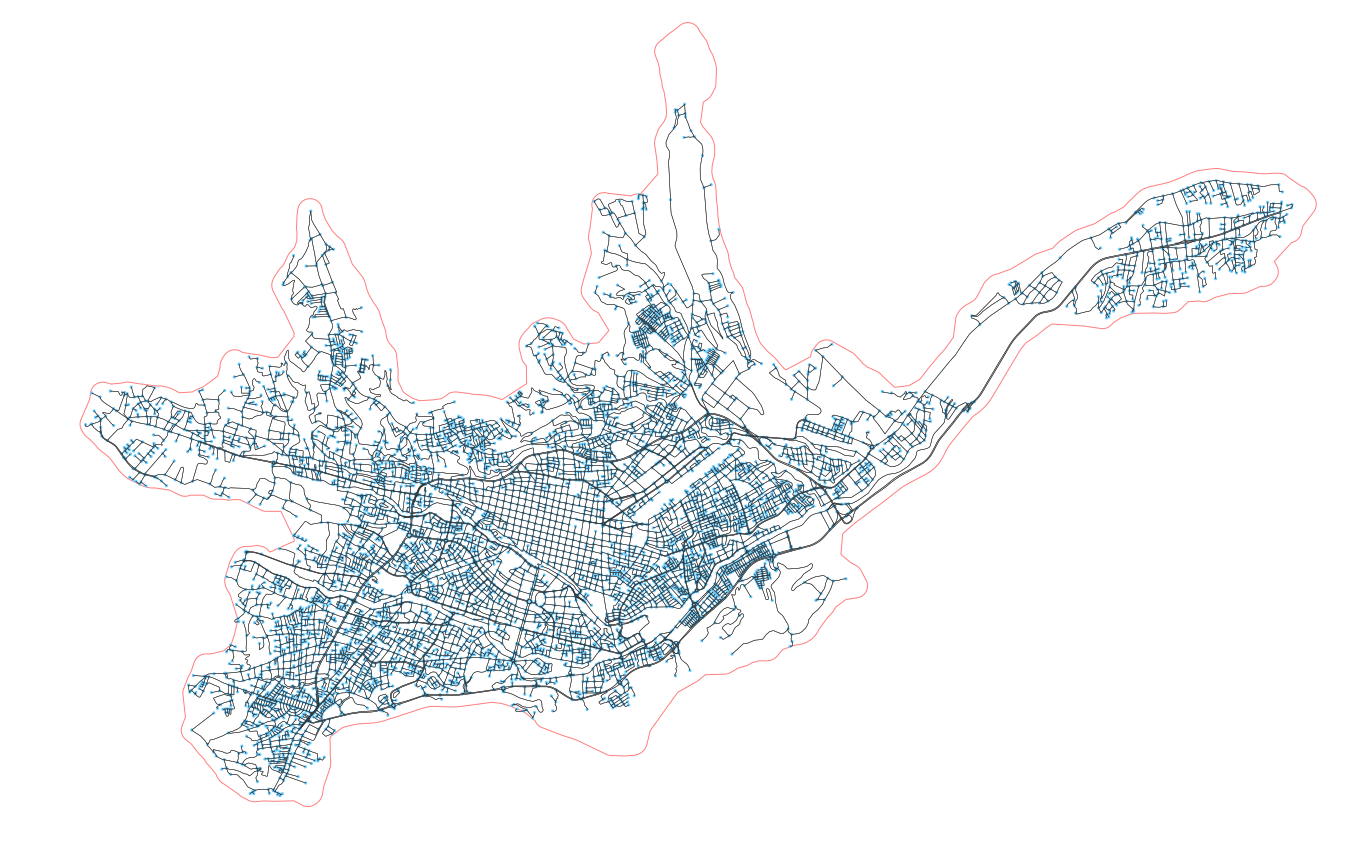

In [7]:
ms.plot_network(street_network, area)

## Get Road Network Stats

## Create Bus Network Graph

plotting results for each line:


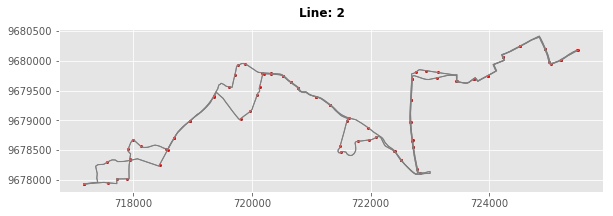

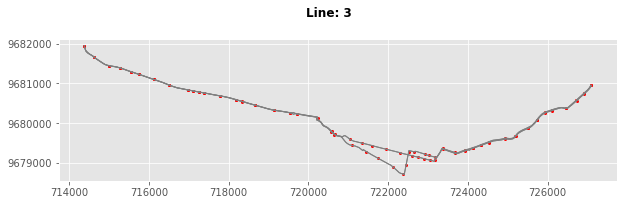

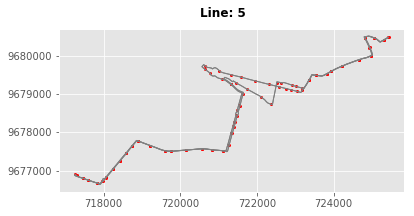

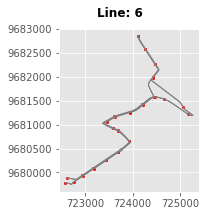

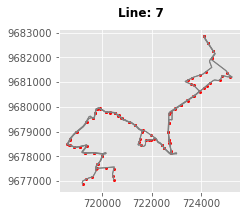

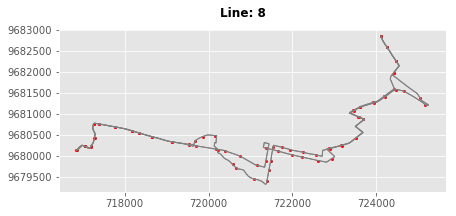

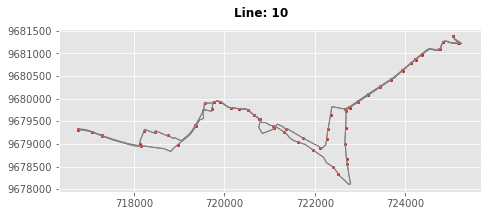

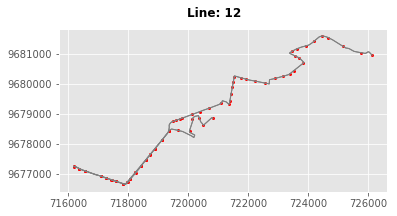

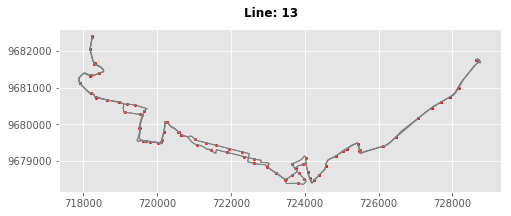

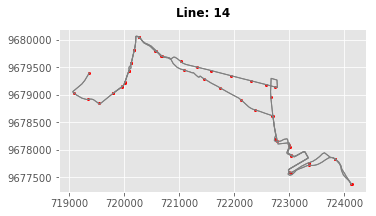

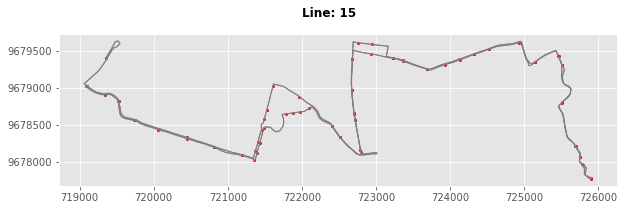

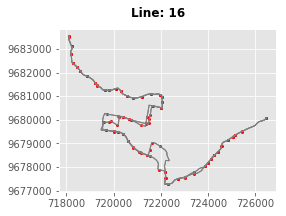

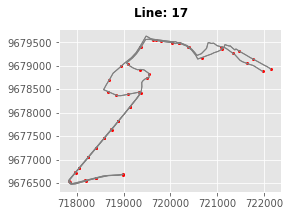

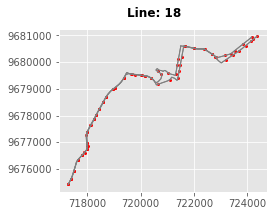

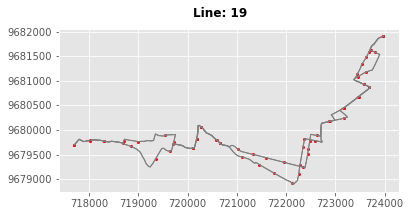

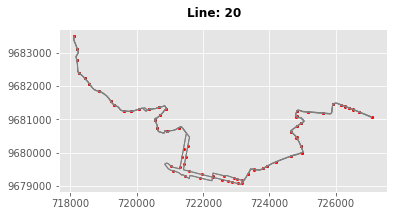

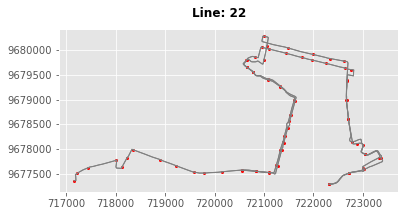

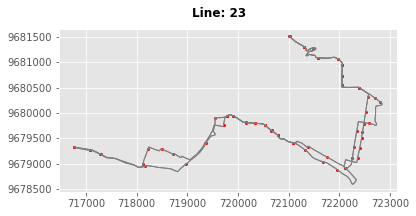

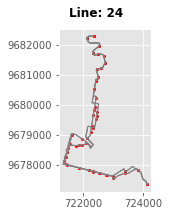

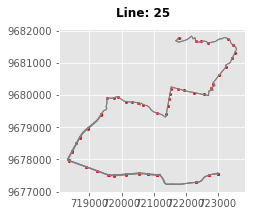

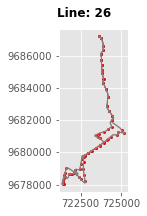

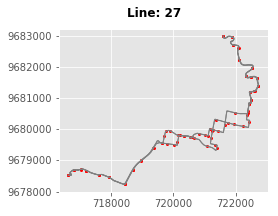

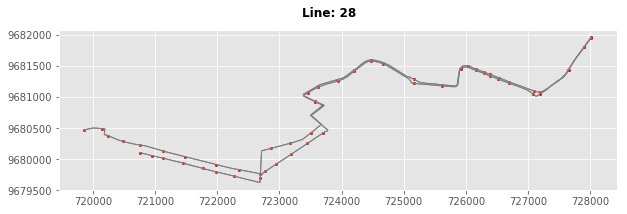

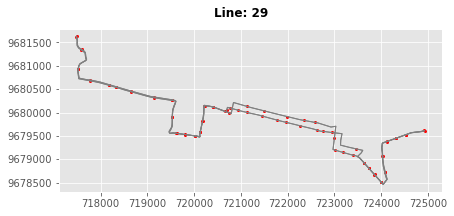

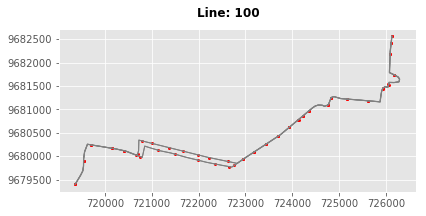

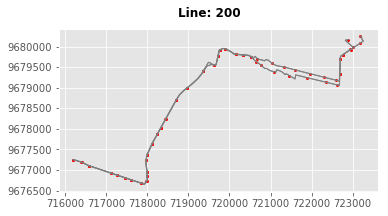

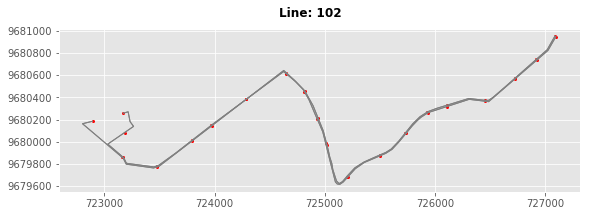

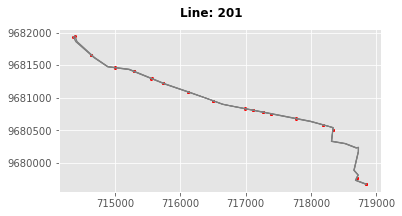

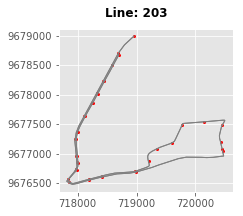

In [8]:
#create bus network
bus_network = ms.construct_bus_network(busLineGPD, busStopGPD, area, speed = 30)
type(bus_network)
#plot bus network graph
ox.save_graph_shapefile(bus_network, folder = graphs_folder, filename = '{}/shapefile'.format('bus_network'))
ox.save_graphml(bus_network, folder = graphs_folder, filename = '{}/graph'.format('bus_network'))

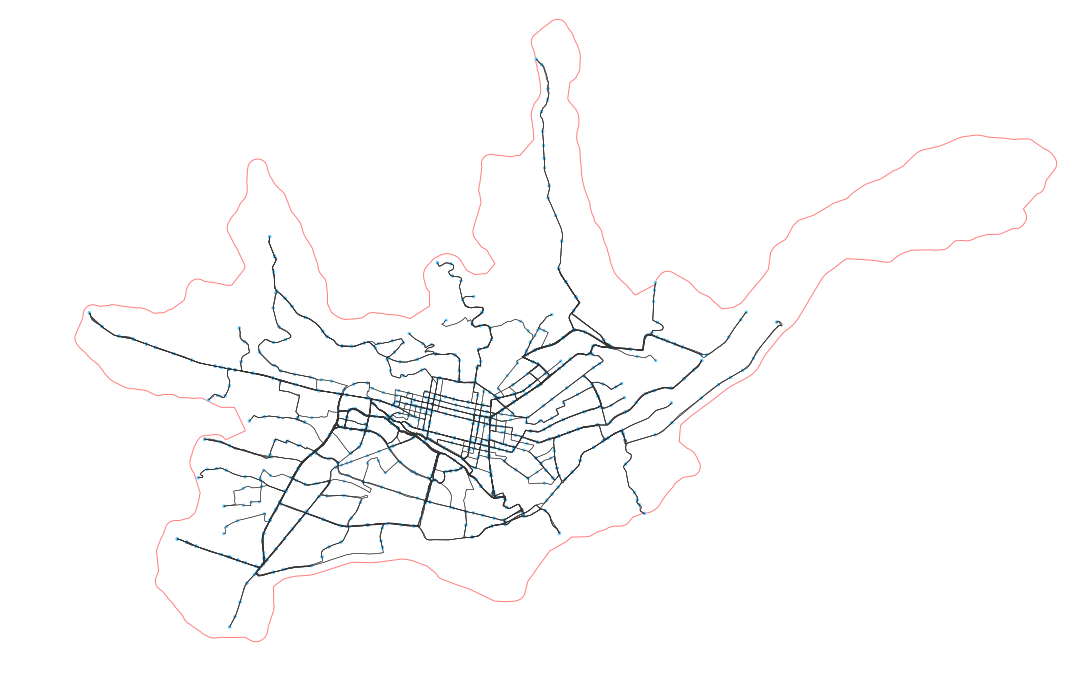

In [9]:
ms.plot_network(bus_network, area)

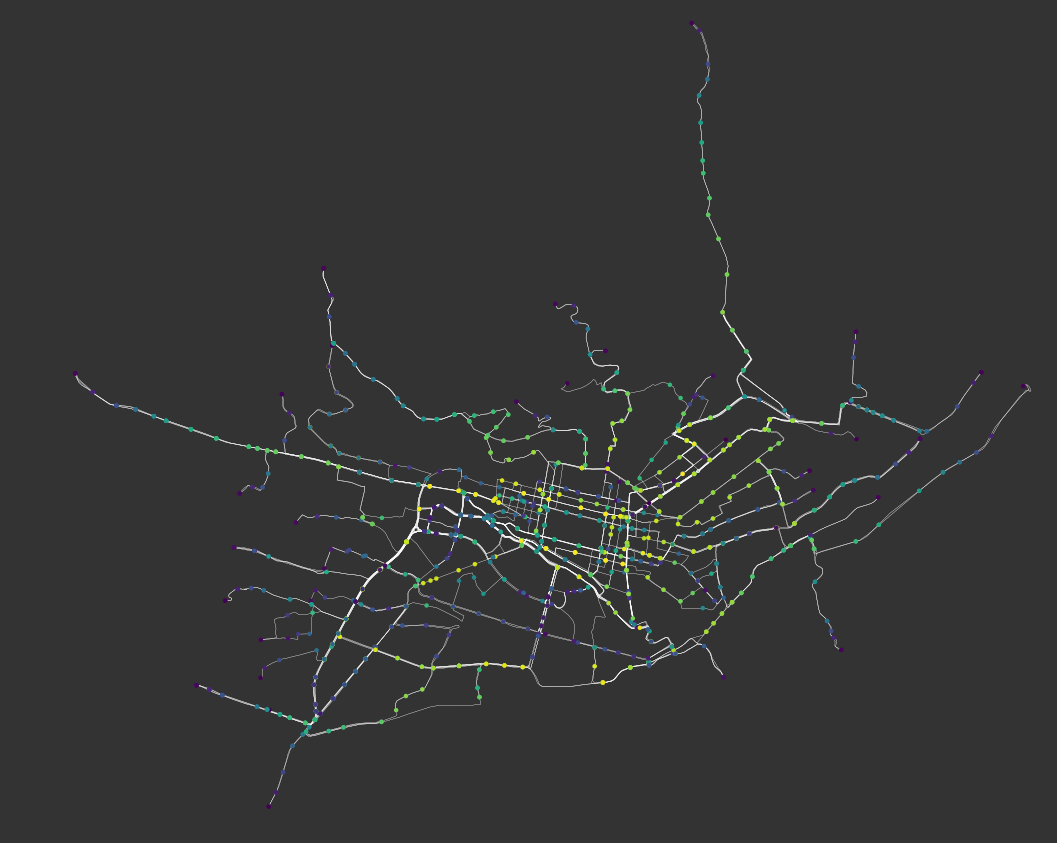

In [325]:
bcw = nx.betweenness_centrality(bus_network, weight= 'weight')
nc = get_node_colors_by_stat(bus_network, data=bcw)
fig, ax = ox.plot_graph(bus_network,
                        fig_height = 15,
                        node_size = 20,
                        node_color = nc,
                        node_zorder=2,
                        edge_color='w',
                        edge_linewidth=0.2,
                        edge_alpha=1,
                        bgcolor = '#333333',
                        save = True, 
                        show = True,
                        close = True,
                        filename = 'bus_stats_{}'.format('bc'), 
                        dpi=1200,
                        equal_aspect=True,
                       )

## Create Tram Network Graph

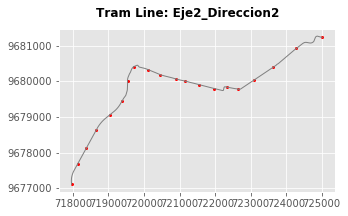

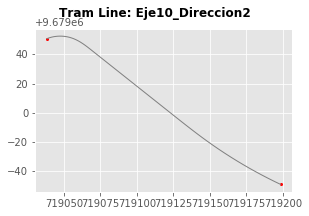

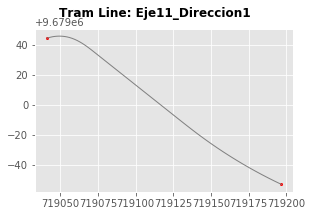

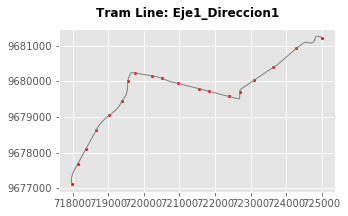

In [10]:
tram_network = ms.create_tram_network(tramLineGPD, tramStopGPD, area)
#plot bus network graph
ox.save_graph_shapefile(tram_network, folder = graphs_folder, filename = '{}/shapefile'.format('tram_network'))
ox.save_graphml(tram_network, folder = graphs_folder, filename = '{}/graph'.format('tram_network'))

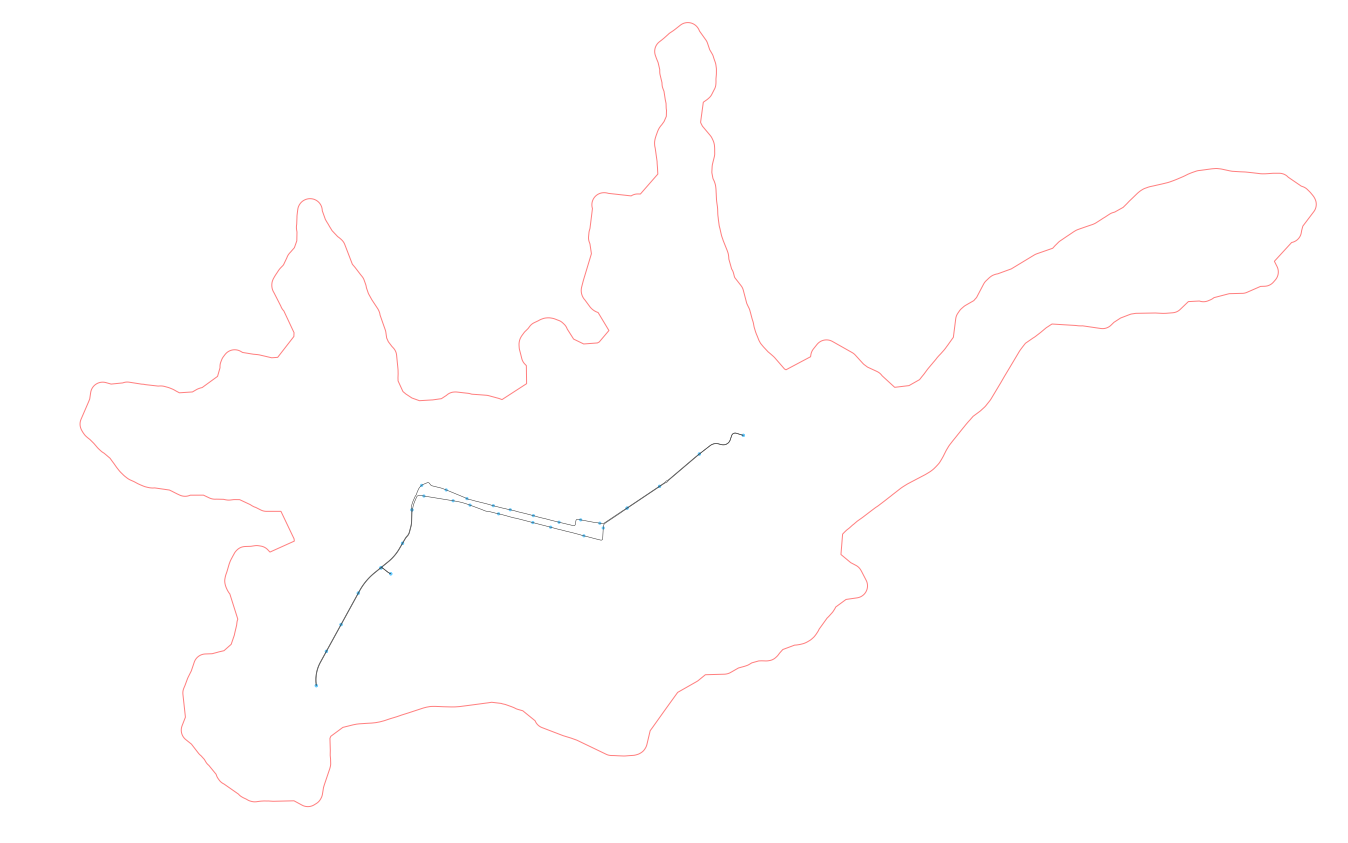

In [11]:
ms.plot_network(tram_network, area)

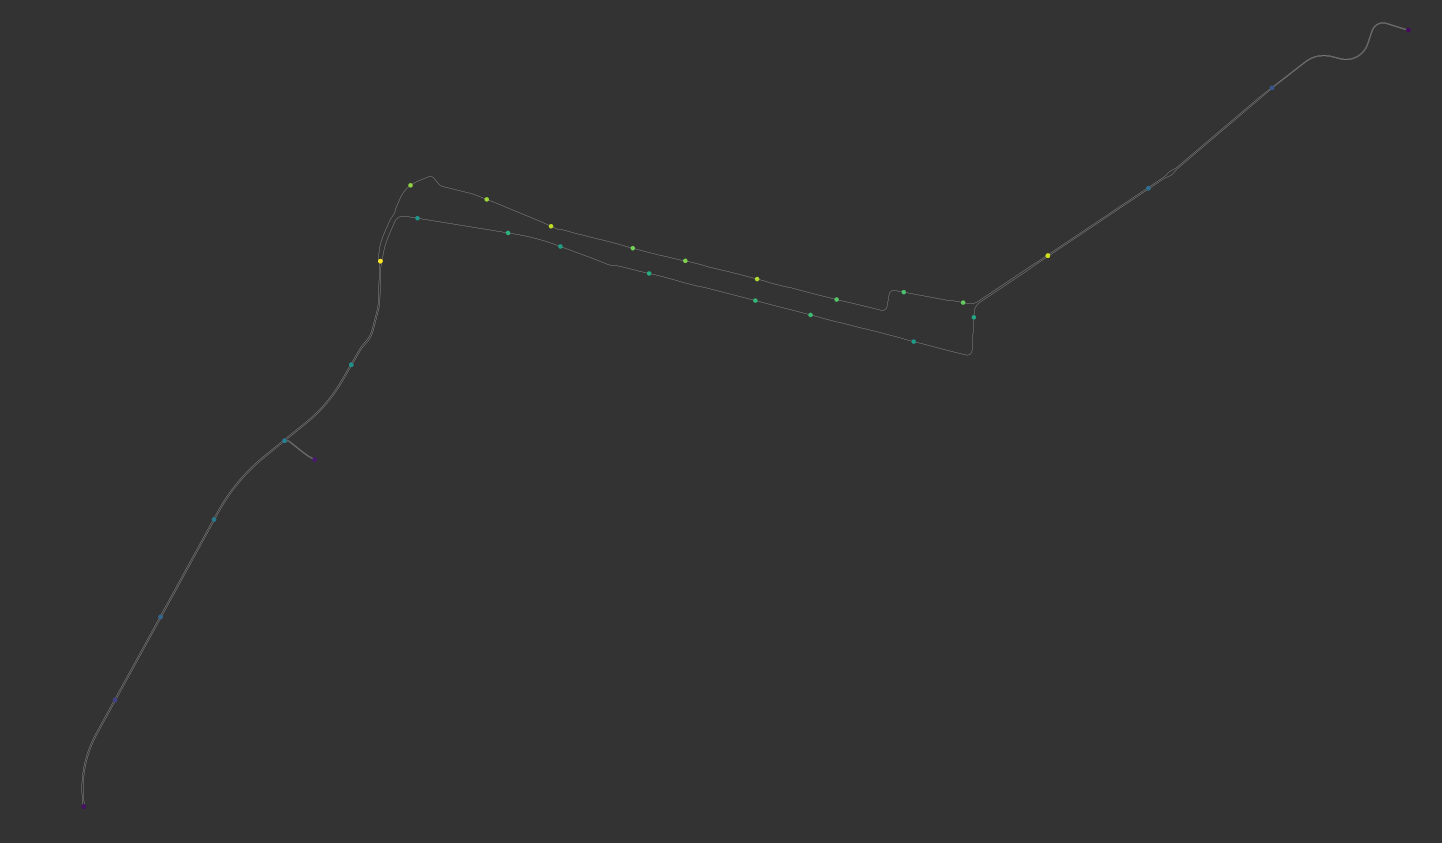

In [330]:
bcw = nx.betweenness_centrality(tram_network, weight= 'weight')
nc = get_node_colors_by_stat(tram_network, data=bcw)
fig, ax = ox.plot_graph(tram_network,
                        fig_height = 15,
                        node_size = 20,
                        node_color = nc,
                        node_zorder=2,
                        edge_color='w',
                        edge_linewidth=0.2,
                        edge_alpha=1,
                        bgcolor = '#333333',
                        save = True, 
                        show = True,
                        close = True,
                        filename = 'tram_stats_{}'.format('bc'), 
                        dpi=1200,
                        equal_aspect=True,
                       )

## Assign Socio Economic Data to Nodes

voronoi tesselation and weighted area overlay interpolation is used to determine population data at each intersection.

In [18]:
#join ICV dataframe to block geometry
blocksICV = blocksGPD.merge(icvIndexDf, left_on = 'DPA_MANZAN', right_on = 'id_man')

#only conserve valid geometries with values
blocksICV = blocksICV[blocksICV.is_valid]
blocksICV = blocksICV.dropna()
blocksICV.to_file('{}/blocksICV'.format(output_path))

Ring Self-intersection at or near point 720396.05939999968 9681490.2802000009


Generating voronoi tesselation...


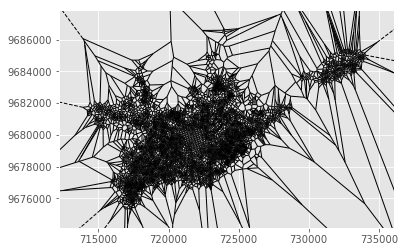

Generating geodataframe...


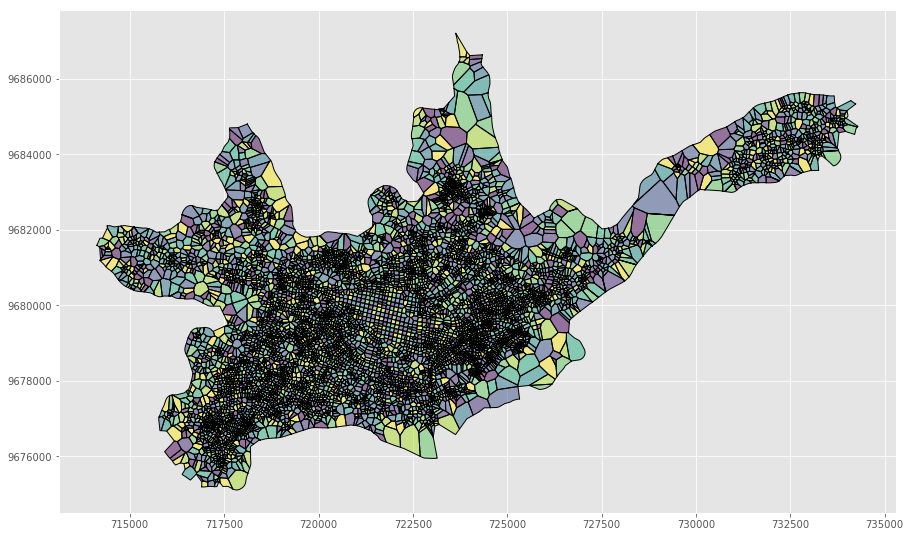

Calculating area overlay...
Calculating values for polygon...
Appending values to geometry...
done!


In [19]:
#map data to intersection
street_network = ms.blocks_to_nodes(street_network, 
                                   blocksICV, 
                                   area, 
                                   crs_utm)
#save to shapefile and graphml
ox.save_graph_shapefile(street_network, folder = graphs_folder, filename = '{}/shapefileICV'.format('street_network'))

## Create Multiplex

In [203]:
multiplex = ms.create_multiplex(street_network, [bus_network, tram_network], [15,10])

In [185]:
ox.save_graph_shapefile(multiplex, folder = graphs_folder, filename = '{}/shapefile'.format('multiplex'))
ox.save_graphml(multiplex, folder = graphs_folder, filename = '{}/graph'.format('multiplex'))

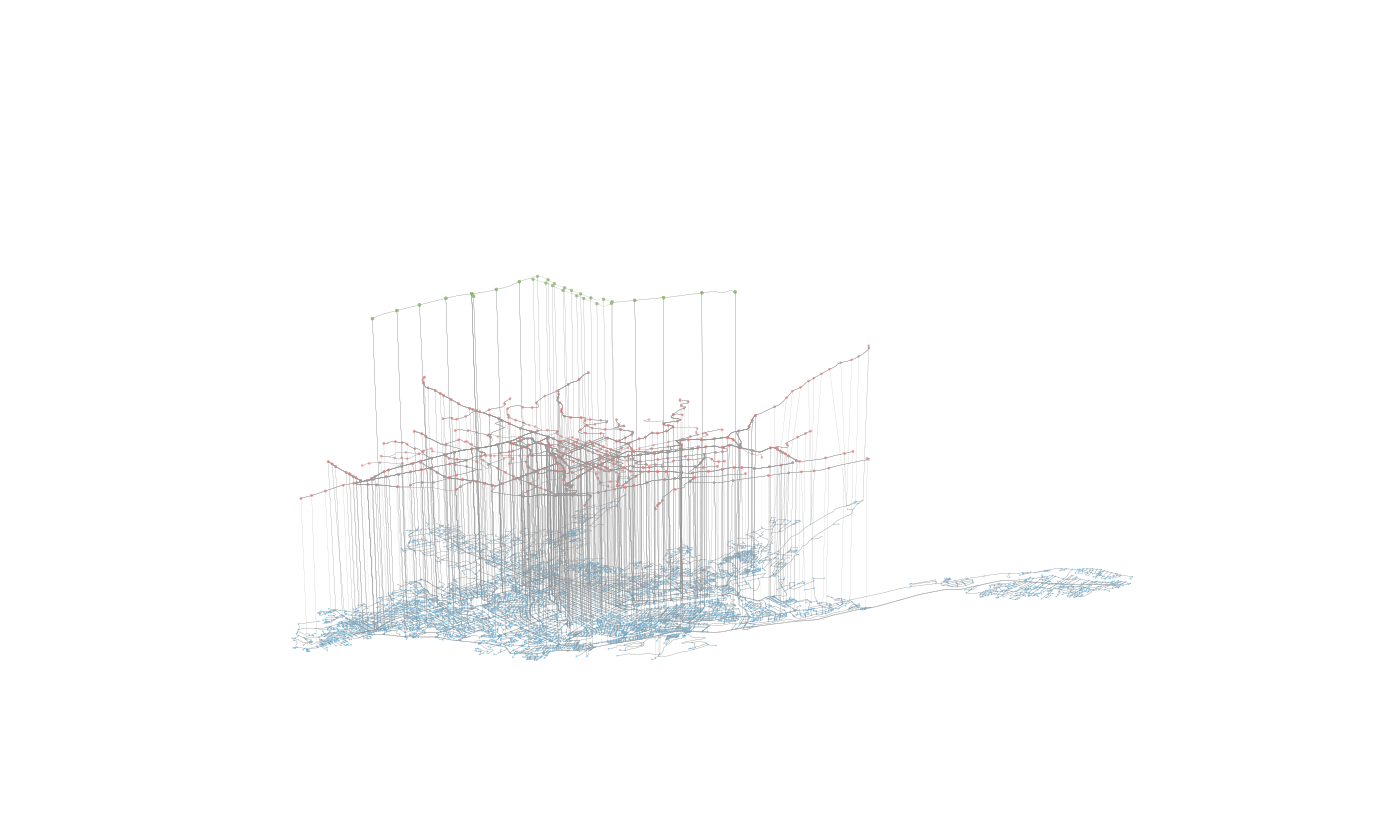

In [215]:
ms.plot_multiplex(multiplex, save = True)

## Random Walk Segregation Index